In [1]:
import numpy as np
import geopandas
import pandas as pd
from sklearn import cluster
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from tqdm import tqdm
import sklearn
from shapely.geometry import Polygon
from shapely import wkt
import re
import geopandas
from shapely import wkt
import random

# Uniquely Connected Counties

In the New York Times [write up](https://www.nytimes.com/interactive/2018/09/19/upshot/facebook-county-friendships.html) of county level Facebook friendship data, one section (*Where History Remains Visible*) pointed out some unexpected relationships between areas as a result of historical migrations:

>Northern cities like Chicago and Milwaukee still retain close ties to Southern counties along the Mississippi River, where African-American workers who were part of the Great Migration starting a century ago left communities for industrial jobs in the North. Kern County, Calif., holds ties today to counties in Oklahoma, where the Dust Bowl in the 1930s led to another significant migration (oil-producing Kern County today is also closely tied to parts of northwest North Dakota that are experiencing an oil boom).

I thought it would be interesting to algorithmically find unique relationships between counties. Here, I will approach this problem by using simple machine learning algorithms (linear regression and k-nearest neighbors), and measuring the difference between the expected number of friendships and the actual number of friendships. Then, the uniquely connected counties are those where the actual number of friendships is much greater than the expected.

## Data set up

In [2]:
# Read in some connectivity data, gathered from the previous scripts
county_conn_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\county_conn.pkl') 
sci_dist_df = pd.read_pickle(r'C:\Users\mgm24\Documents\datasets\sci_dist.pkl')
geo_dist = np.load(r'C:\Users\mgm24\Documents\datasets\geo_dist.npy')
sci_dist_df.head(5)

fr_loc,1001,1003,1005,1007,1009,1011,1013,1015,1017,1019,...,56027,56029,56031,56033,56035,56037,56039,56041,56043,56045
user_loc,,,,,,,,,,,,,,,,,,,,,
1001,1.117710e-07,9.804210e-06,7.443744e-06,3.927421e-06,1.488184e-05,2.330883e-06,0.000001,0.000014,0.000009,0.000028,...,0.000573,0.000597,0.000418,0.000810,0.000730,0.000561,0.000344,0.000731,0.001028,0.001453
1003,9.804210e-06,3.172975e-07,1.997443e-05,1.228879e-05,1.490024e-05,3.052969e-05,0.000006,0.000016,0.000025,0.000026,...,0.000805,0.000371,0.000298,0.000522,0.000279,0.000634,0.000158,0.000521,0.000717,0.000442
1005,7.443744e-06,1.997443e-05,2.212110e-08,3.133912e-05,5.388512e-05,1.598885e-07,0.000004,0.000018,0.000006,0.000060,...,0.000738,0.000713,0.001277,0.001645,0.001242,0.001695,0.000350,0.002358,0.001427,0.001580
1007,3.927421e-06,1.228879e-05,3.133912e-05,2.434424e-08,4.175470e-06,1.999440e-05,0.000008,0.000012,0.000028,0.000023,...,0.002273,0.000667,0.000647,0.001488,0.000774,0.001898,0.001058,0.001502,0.001391,0.001019
1009,1.488184e-05,1.490024e-05,5.388512e-05,4.175470e-06,7.533211e-08,7.212926e-05,0.000034,0.000005,0.000038,0.000006,...,0.002457,0.000709,0.000665,0.000320,0.001105,0.000487,0.000668,0.001079,0.000875,0.000513


In [3]:
# vectorize pairwise distances
sci_dist_df = pd.melt(sci_dist_df, ignore_index=False) 
sci_dist = np.asarray(sci_dist_df['value'])
geo_dist = geo_dist.reshape((geo_dist.shape[0]**2,1)) #this reorganizes elements in the same way as pd.melt
sci_dist_df.head(5)

,fr_loc,value
user_loc,,
1001,1001,1.117710e-07
1003,1001,9.804210e-06
1005,1001,7.443744e-06
1007,1001,3.927421e-06
1009,1001,1.488184e-05


In [4]:
# Convert sci_dist into a connectedness measure
sci_dist_df['geo_dist'] = geo_dist
sci_dist_df['SDI'] = sci_dist_df['value']
sci_dist_df['SCI'] = 1/sci_dist_df['value']
# sci = 1/sci_dist

## Linear regression

First, I'll try a simple linear regression, using the counties distance to predict their social connectedness. Let's look at our variables and make sure they're approximately normally distributed:

Text(0.5, 1.0, 'SCI')

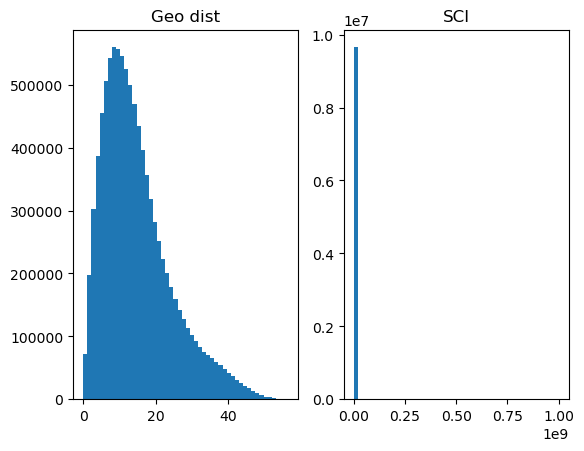

In [5]:
plt.subplot(1,2,1)
_ = plt.hist(sci_dist_df['geo_dist'], bins=50)
plt.title('Geo dist')
plt.subplot(1,2,2)
_ = plt.hist(sci_dist_df['SCI'], bins=50)
plt.title('SCI')

They are certainly not normally distributed! Let's take their logs:

Text(0.5, 1.0, 'Log SCI')

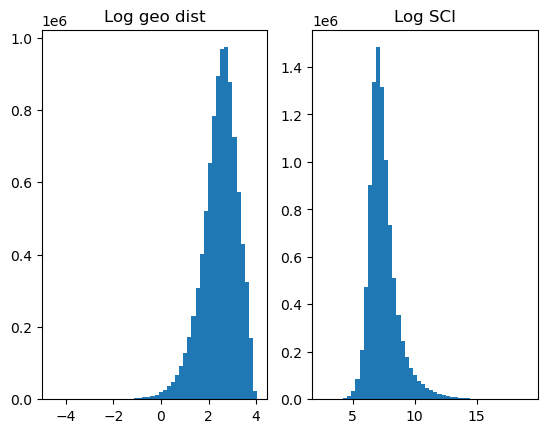

In [107]:
# Log scale
sci_dist_df = sci_dist_df[sci_dist_df['geo_dist']>0]
sci_dist_df['log_geo_dist'] = np.log(sci_dist_df['geo_dist'])
sci_dist_df['log_SCI'] = np.log(sci_dist_df['SCI'])
sci_dist_df['log_log_SCI'] = np.log(sci_dist_df['log_SCI'])
plt.subplot(1,2,1)
_ = plt.hist(sci_dist_df['log_geo_dist'], bins=50)
plt.title('Log geo dist')
plt.subplot(1,2,2)
_ = plt.hist(sci_dist_df['log_SCI'], bins=50)
plt.title('Log SCI')

The SCI is much better than before, and the geo distance is about the same. Let's also remove those outliers near 0 for SCI

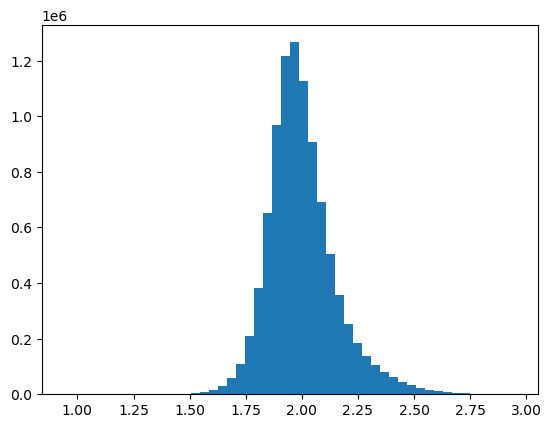

In [89]:
# Remove outliers
sci_dist_df = sci_dist_df[sci_dist_df['log_SCI']>.1]
_ = plt.hist(sci_dist_df['log_log_SCI'], bins=50)

Now, let's plot the relationship between the geographical distance and Social Connectedness Index: Since we're only interested in when social distance is unexpectadly small when the counties are geographically distant, we'll remove the counties where the geographical distance is small.

Samples with a distance greater than 4.511534669127608: 8707544


Text(0, 0.5, 'Social connectedness')

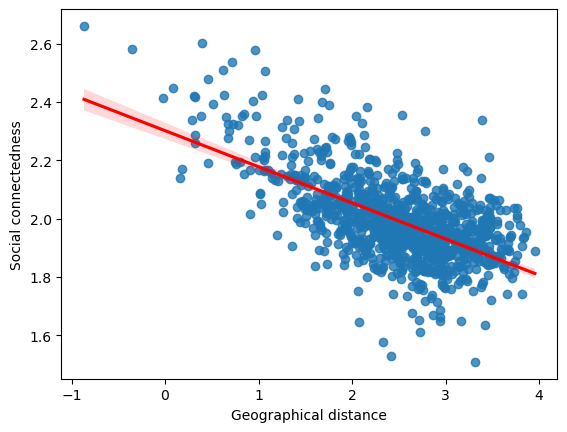

In [119]:
dist = np.percentile(sci_dist_df['geo_dist'], 10)
print('Samples with a distance greater than '+str(dist)+': '+ str(np.sum(geo_dist>dist)))
# sci_dist_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
sns.regplot(x=sci_dist_df.iloc[samples]['log_geo_dist'], y=sci_dist_df.iloc[samples]['log_log_SCI'],
           line_kws={"color": "red"})
# plt.scatter(np.log(geo_far[samples]), np.log(sci_far[samples]))
plt.xlabel('Geographical distance')
plt.ylabel('Social connectedness')

It looks like a linear model is an ok fit for the data. Still, the relationship is not perfectly linear: when geographical distance is low, the model usually predicts the social connectedness will be lower then it actually is. We'll try this model out, but this could lead to some problems...

In [9]:
# Run the model, get the residuals
results = sm.OLS(sci_dist_df['log_geo_dist'], sci_dist_df['log_SCI']).fit()
residuals = results.resid
sci_dist_df['resid'] = -residuals
# plt.xlim(-.003, .006)

Let's look at the results. We're interested in counties with a much smaller social distance than expected, or where the residual (x - predict(x)) is positive.

To do so, let's add in the name and states of these counties, so we can better identify them:

In [10]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data = county_data.set_index('fips')
county_data_select = county_data.loc[:, ['county', 'state']]
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'user_county', 'state':'user_state'})
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(county_data_select, how='left')
sci_dist_df = sci_dist_df.rename(columns={'county':'fr_county', 'state':'fr_state'})
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df.sort_values('resid', ascending=False).head(10)

,value,geo_dist,SDI,SCI,log_geo_dist,log_SCI,resid,user_county,user_state,user_loc,fr_county,fr_state,fr_loc
51690,5.751096e-08,0.010339,5.751096e-08,17387990.0,-4.571856,16.671290,9.745036,Henry,VIRGINIA,51089,Martinsville City,VIRGINIA,51690
51089,5.751096e-08,0.010339,5.751096e-08,17387990.0,-4.571856,16.671290,9.745036,Martinsville City,VIRGINIA,51690,Henry,VIRGINIA,51089
51580,1.987960e-08,0.022206,1.987960e-08,50302819.0,-3.807375,17.733572,9.310185,Alleghany,VIRGINIA,51005,Covington City,VIRGINIA,51580
51005,1.987960e-08,0.022206,1.987960e-08,50302819.0,-3.807375,17.733572,9.310185,Covington City,VIRGINIA,51580,Alleghany,VIRGINIA,51005
51678,4.964385e-08,0.022425,4.964385e-08,20143481.0,-3.797596,16.818391,9.016422,Rockbridge,VIRGINIA,51163,Lexington City,VIRGINIA,51678
51163,4.964385e-08,0.022425,4.964385e-08,20143481.0,-3.797596,16.818391,9.016422,Lexington City,VIRGINIA,51678,Rockbridge,VIRGINIA,51163
51081,1.789864e-08,0.030777,1.789864e-08,55870163.0,-3.480998,17.838541,9.016381,Emporia City,VIRGINIA,51595,Greensville,VIRGINIA,51081
51595,1.789864e-08,0.030777,1.789864e-08,55870163.0,-3.480998,17.838541,9.016381,Greensville,VIRGINIA,51081,Emporia City,VIRGINIA,51595
51775,3.177099e-07,0.021212,3.177099e-07,3147525.0,-3.853182,14.962127,8.496001,Roanoke,VIRGINIA,51161,Salem City,VIRGINIA,51775
51161,3.177099e-07,0.021212,3.177099e-07,3147525.0,-3.853182,14.962127,8.496001,Salem City,VIRGINIA,51775,Roanoke,VIRGINIA,51161


The must surprisingly connected counties, according to this model, are all in the west, and pretty close together geographically. Now we'll add in the geographical information, so we can plot things better:

In [11]:
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)
county_data = county_data.set_index('fips')

geometry_data = county_data.loc[:, ['geometry']]
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(geometry_data, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = geopandas.GeoDataFrame(sci_dist_df)

In [75]:
def plot_suprising_counties(sci_dist_df, user_loc, resid, n_counties=10):
    tc_df = sci_dist_df[sci_dist_df['user_loc']==user_loc]
    fig, ax = plt.subplots(figsize=(11,10))
    tc_df.plot('SCI', ax=ax, vmin=0, vmax=10000)
    tc_df.sort_values(resid, ascending=False).head(n_counties).boundary.plot(color='red', ax=ax)
    tc_df = sci_dist_df[sci_dist_df['fr_loc']==user_loc].plot(color='black', ax=ax)
    

In [65]:
    tc_df = sci_dist_df[sci_dist_df['user_loc']==user_loc]

1001     POLYGON ((-86.92120 32.65755, -86.92036 32.658...
1001     POLYGON ((-86.92120 32.65755, -86.92036 32.658...
1001     POLYGON ((-86.92120 32.65755, -86.92036 32.658...
1001     POLYGON ((-86.92120 32.65755, -86.92036 32.658...
1001     POLYGON ((-86.92120 32.65755, -86.92036 32.658...
                               ...                        
56045    POLYGON ((-105.08079 43.96622, -105.07929 44.1...
56045    POLYGON ((-105.08079 43.96622, -105.07929 44.1...
56045    POLYGON ((-105.08079 43.96622, -105.07929 44.1...
56045    POLYGON ((-105.08079 43.96622, -105.07929 44.1...
56045    POLYGON ((-105.08079 43.96622, -105.07929 44.1...
Name: geometry, Length: 9487374, dtype: geometry

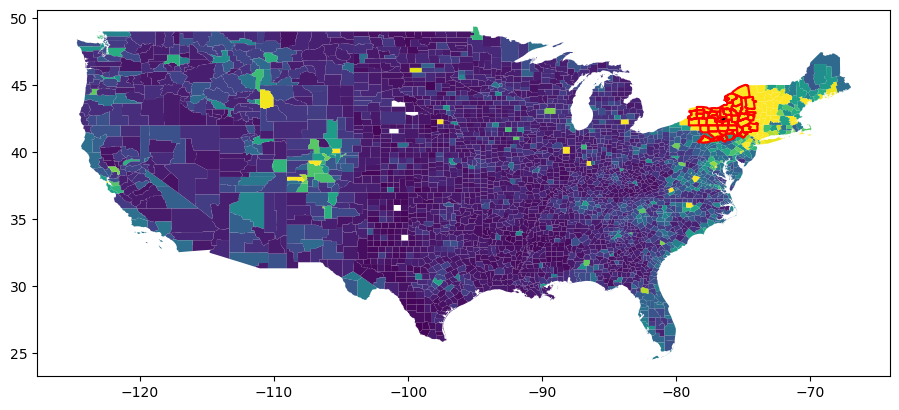

In [76]:
plot_suprising_counties(sci_dist_df, 36109, 'resid', 50)

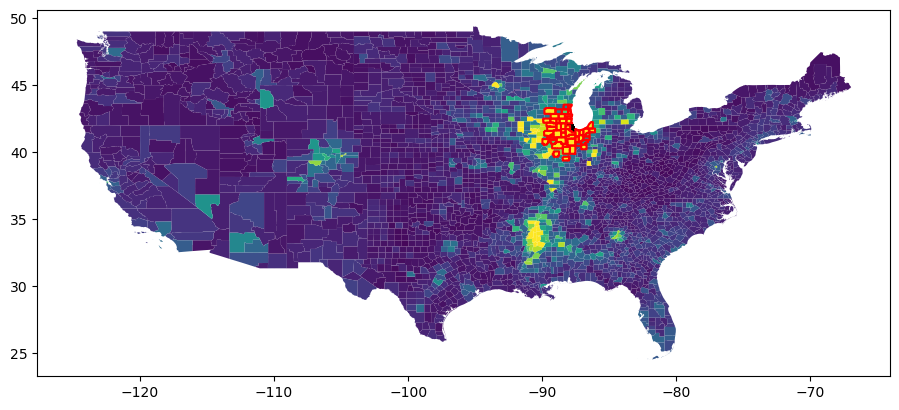

In [77]:
plot_suprising_counties(sci_dist_df, 17031, 'resid', 50)

This model favors nearby counties. This could be because of non-linearities in the relationship between friendship and geographical distance.

In [15]:
density_info = pd.read_excel(r'C:\Users\mgm24\Documents\datasets\URAmericaMapCountyList.xlsx', header=3, index_col='CountyFIPS') #index_col='CountyFIPS'
density_info = density_info.loc[:, ['Density2016_SqMi', 'Population2016']]
# density_info = density_info.loc[:, 'Density2016_SqMi']
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Density2016_SqMi':'user_density', 'Population2016':'user_pop'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(density_info, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'Density2016_SqMi':'fr_density', 'Population2016':'fr_pop'})

In [16]:
sci_dist_df['pairdensity_avg'] = (sci_dist_df['user_density'] + sci_dist_df['fr_density']) / 2

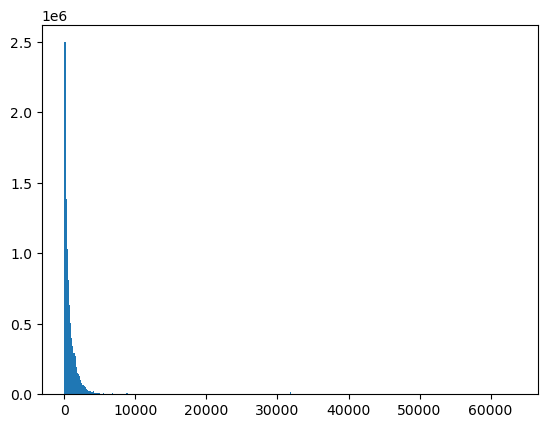

In [17]:
_ = plt.hist(sci_dist_df['pairdensity_avg'], bins=400)

Again, this is not normally distributed: let's take the log.

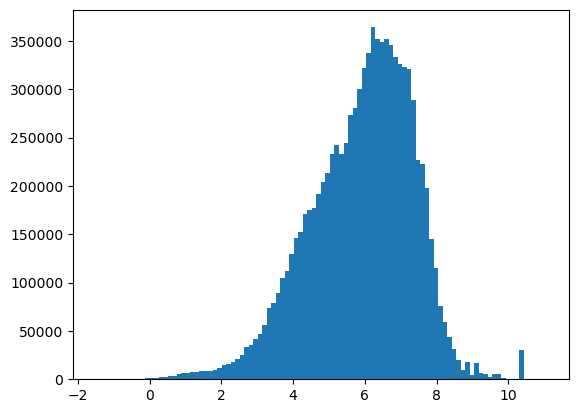

In [18]:
_ = plt.hist(np.log(sci_dist_df['pairdensity_avg']), bins=100)

That's more acceptable. Looking at the relationship between the residuals and the population density:

<AxesSubplot:xlabel='log_pairdensity', ylabel='resid'>

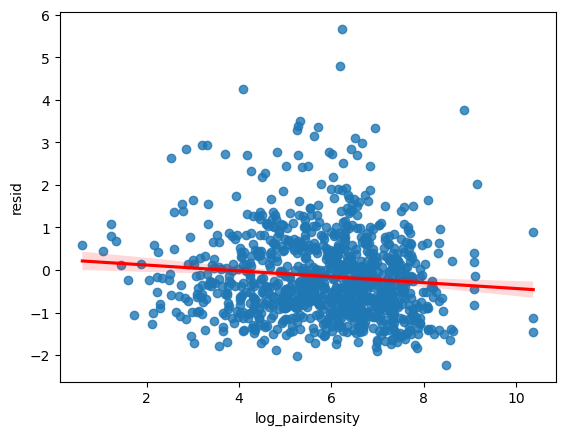

In [19]:
sci_dist_df['log_pairdensity'] = np.log(sci_dist_df['pairdensity_avg'])
samples = random.sample(range(sci_dist_df.shape[0]), 1000)
sns.regplot(data=sci_dist_df.iloc[samples], x='log_pairdensity', y='resid',
           line_kws={"color": "red"})
# plt.xlim(0, 25)

There is indeed a relationship between the residuals and the population density of the counties: as the population density of the counties increases, the residual increases as well. This means lower population density leads the regression to predict a lower social distance than actually observed. This makes sense, as in population sparse regions, friendships are likely farther apart.

Now, let's run a regression including both geographic distances and population density.

In [20]:
results = sm.OLS(sci_dist_df['SCI'], sci_dist_df[['log_geo_dist','log_pairdensity']]).fit()

sci_dist_df['geo_density_resid'] = results.resid

Now, the county pairings with unexpectadly high social connections are all very far apart, which is more of the kinds of pairs we're interested in.

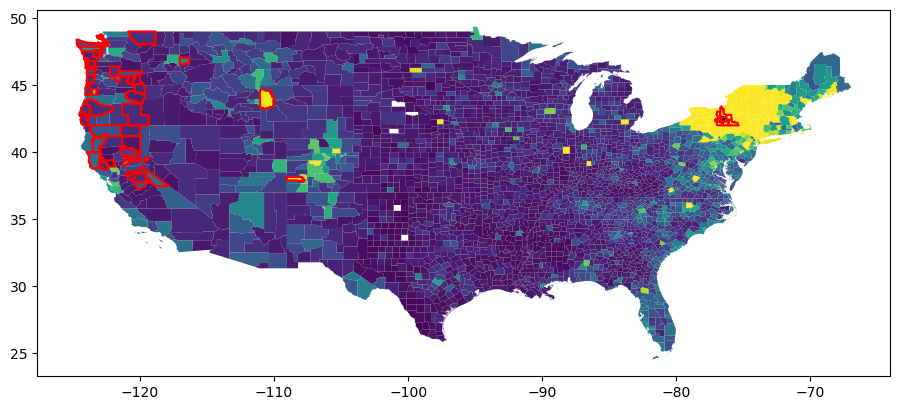

In [78]:
plot_suprising_counties(sci_dist_df, 36109, 'geo_density_resid', n_counties=50)

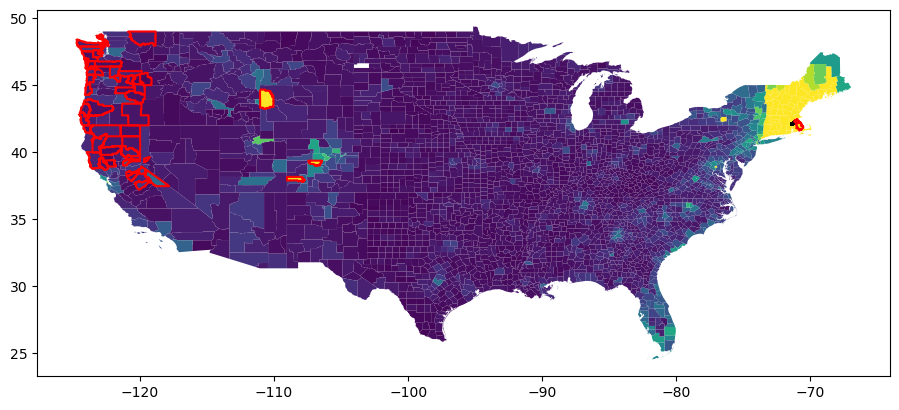

In [79]:
# Norfolk county?
plot_suprising_counties(sci_dist_df, 25021, 'geo_density_resid', n_counties=50)

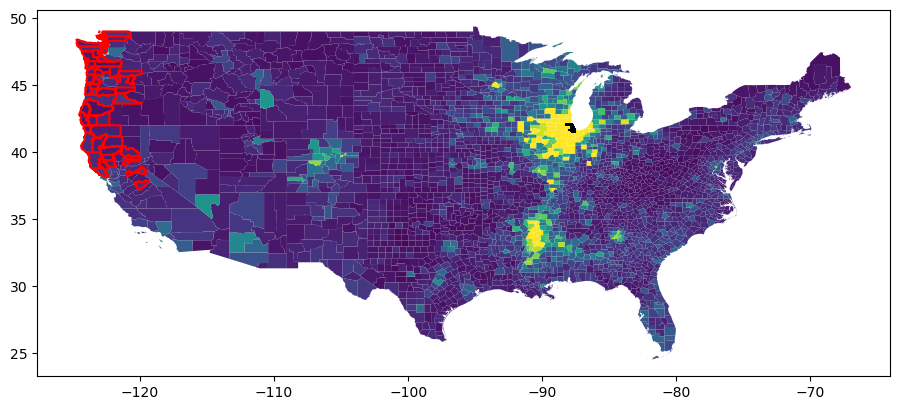

In [80]:
# cook county?
plot_suprising_counties(sci_dist_df, 17031, 'geo_density_resid', n_counties=50)

These results are cetainly a step forward. Still, they aren't perfect. The main problem in my opinion is the model really favors counties that are very far apart. Really, the relationship between social distance and geographical distance is likely nonlinear, such that after a certain geographical distance, social distances likely stop decreasing nearly as much. Let's try a regression capable of modeling these non-linearities: a K-nearest neighbors regression should do the trick.

In [24]:
n_neighbors = 100000
knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=50, weights='uniform')
# X = sci_dist_df[['log_geo_dist','log_pairdensity']]
X = sci_dist_df[['geo_dist']]
y = sci_dist_df['SCI']
results = knn_model.fit(X, y)

In [25]:
if n_neighbors < 20:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_resid'] = residuals
else:
    # predict in batches (to avoid memory error)
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_resid'] = np.asarray(Yy - predictions)

100%|██████████████████████████████████████████████████████████████████████████████| 9487/9487 [02:40<00:00, 58.94it/s]


In [26]:
sci_dist_df.sort_values('knn_resid', ascending=True).head(5)

,value,geo_dist,SDI,SCI,log_geo_dist,log_SCI,resid,user_county,user_state,fr_county,...,user_density,user_pop,user_loc,fr_density,fr_pop,fr_loc,pairdensity_avg,log_pairdensity,geo_density_resid,knn_resid
8641349,0.000006,0.579221,0.000006,159545.0,-0.546071,11.980081,4.263547,Prince George,VIRGINIA,Isle of Wight,...,1352.757522,37845,51149,332.972172,36596,51093,842.864847,6.736807,41427.726676,-13938062.8
8720527,0.000006,0.579221,0.000006,159545.0,-0.546071,11.980081,4.263547,Isle of Wight,VIRGINIA,Prince George,...,332.972172,36596,51093,1352.757522,37845,51149,842.864847,6.736807,41427.726676,-13938062.8
7321893,0.000003,0.579228,0.000003,324915.0,-0.546059,12.691319,4.484235,Warren,TENNESSEE,Bledsoe,...,303.915498,40516,47177,36.588427,14675,47007,170.251963,5.137279,230598.529669,-13772692.8
7583478,0.000003,0.579228,0.000003,324915.0,-0.546059,12.691319,4.484235,Bledsoe,TENNESSEE,Warren,...,36.588427,14675,47007,303.915498,40516,47177,170.251963,5.137279,230598.529669,-13772692.8
2273678,0.000002,0.579220,0.000002,403489.0,-0.546073,12.907905,4.551456,Carroll,INDIANA,Tipton,...,187.541949,19970,18015,113.047049,15182,18159,150.294499,5.012597,311027.316639,-13694118.8


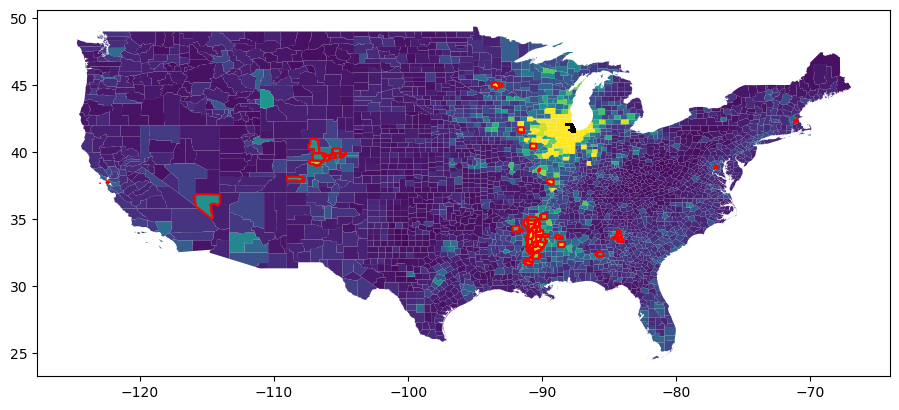

In [81]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_resid', n_counties=50)

This misses the Mississipi river counties, probably because in the west, far apart counties still have lots of connections, meaning the model is not that surprised to see counties at this distance have lots of connections.

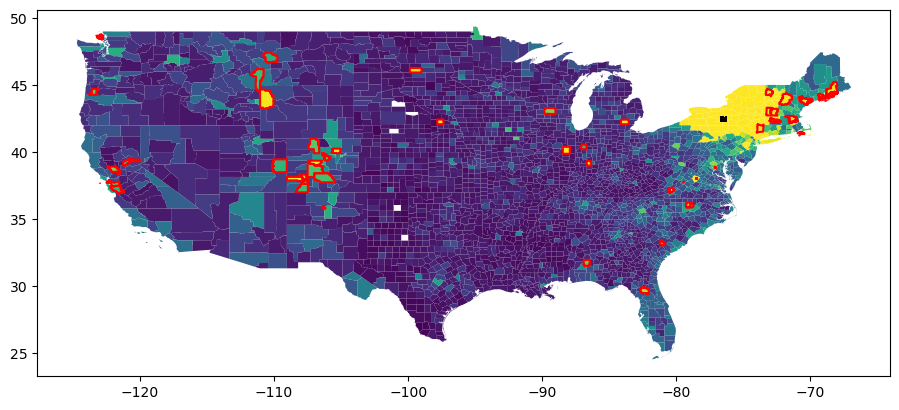

In [82]:
plot_suprising_counties(sci_dist_df, 36109, 'knn_resid', n_counties=50)

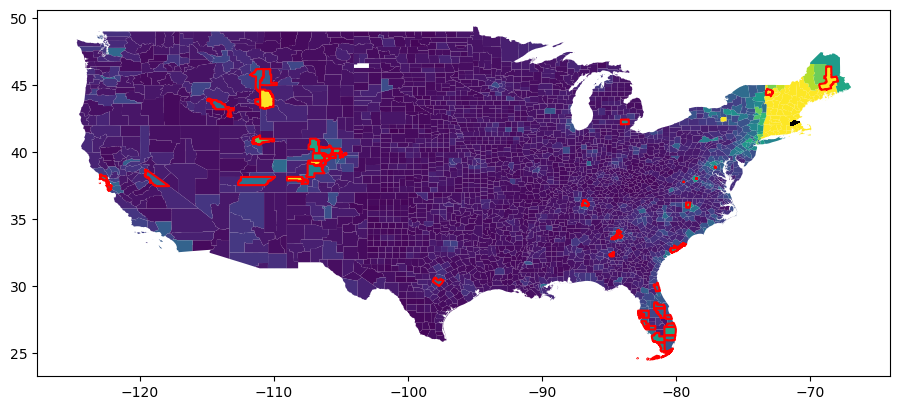

In [83]:
plot_suprising_counties(sci_dist_df, 25021, 'knn_resid', n_counties=50)

In [30]:
# Get x, y coords
county_data = pd.read_csv('G:\My Drive\ds_projects\cdcs-social-vulnerability-index-svi-2016-overall-svi-county-level.csv')
county_data['geometry'] = county_data['geometry'].apply(wkt.loads)
county_data = geopandas.GeoDataFrame(county_data)

# Convert r Polygon text to shapely polygon
for row_idx, row in county_data.iterrows():
    points = re.findall(r'-?\d+.\d+', row['geometry'].wkt)
    i = 0
    list_points = []
    while i < len(points):
        list_points.append((float(points[i]), float(points[i+1])))
        i+=2
    list_points

    county_shape = Polygon(list_points)
    county_center = county_shape.centroid
    center_points = re.findall(r'-?\d+.\d+', county_center.wkt)
    county_data.at[row_idx, 'center_long'] = float(center_points[0])
    county_data.at[row_idx, 'center_lat'] = float(center_points[1])

In [31]:
# Try including x, y coords in model
county_data = county_data.set_index('fips')
center_loc = county_data.loc[:, ['center_long', 'center_lat']]
sci_dist_df = sci_dist_df.set_index('user_loc')
sci_dist_df = sci_dist_df.join(center_loc, how='left')
sci_dist_df['user_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'center_long':'user_center_long', 'center_lat':'user_center_lat'})
sci_dist_df = sci_dist_df.set_index('fr_loc')
sci_dist_df = sci_dist_df.join(center_loc, how='left')
sci_dist_df['fr_loc'] = sci_dist_df.index
sci_dist_df = sci_dist_df.rename(columns={'center_long':'fr_center_long', 'center_lat':'fr_center_lat'})

In [32]:
n_neighbors = 10

knn_model = sklearn.neighbors.KNeighborsRegressor(n_neighbors=n_neighbors, weights='uniform')
X = sci_dist_df[['user_center_long','user_center_lat','fr_center_long','fr_center_lat']]
y = sci_dist_df['SCI']
results = knn_model.fit(X, y)

if n_neighbors < 25:
    predictions = knn_model.predict(X)
    residuals = y - predictions
    sci_dist_df['knn_xy_resid'] = residuals

else: #predict in batch to avoid memory error
    batch_size = 1000
    batches = np.arange(0, sci_dist_df.shape[0], batch_size)
    batches = batches[:-1] #remove last batch
    sci_dist_df.reset_index(inplace=True, drop=True)
    sci_dist_df['knn_resid'] = np.nan
    for batch in tqdm(batches, total=len(batches)):
        Xx = X[batch:batch+batch_size]
        Yy = y[batch:batch+batch_size]
        predictions = knn_model.predict(Xx)
        sci_dist_df.loc[batch:batch+batch_size-1, 'knn_xy_resid'] = np.asarray(Yy - predictions)

    Xx = X[batch+batch_size:]
    Yy = y[batch+batch_size:]
    predictions = knn_model.predict(Xx)
    sci_dist_df.loc[batch+batch_size:, 'knn_xy_resid'] = np.asarray(Yy - predictions)


KeyboardInterrupt: 

In [ ]:
plot_suprising_counties(sci_dist_df, 17031, 'resid', n_counties=0)

In [ ]:
plot_suprising_counties(sci_dist_df, 17031, 'resid', n_counties=50)

In [ ]:
plot_suprising_counties(sci_dist_df, 17031, 'geo_density_resid', n_counties=50)

In [ ]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_resid', n_counties=50)

In [ ]:
plot_suprising_counties(sci_dist_df, 17031, 'knn_xy_resid', n_counties=50)

In [ ]:
# Filter on avg pop
dist = np.percentile(sci_dist_df['geo_dist'], 50)
geofar_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
sci_dist_df['avg_pop'] = (sci_dist_df['user_pop']+sci_dist_df['fr_pop'])/2
pop = np.percentile(sci_dist_df['avg_pop'], 50)
dist = np.percentile(sci_dist_df['geo_dist'], 50)
filtdist_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
filtdistpop_df = filtdist_df[filtdist_df['avg_pop']>pop]

filtdistpop_df.sort_values('geo_density_resid', ascending=False)[['user_loc','user_county','user_state','fr_county','fr_state']].head(10)

Another interesting pairing: Utah, Utah and Buena Vista City:

In [ ]:
plot_suprising_counties(sci_dist_df, 51530, 'geo_density_resid', n_counties=50)

It turns out, Buena Vista City Virginia is home to Southern Virginia University, a [Mormon University](https://archive.sltrib.com/article.php?id=9363275&itype=NGPSID)!

Now, let's filter the data to see if we get more interesting results after filtering on each population:

In [ ]:
# Filter on each pop
dist = np.percentile(sci_dist_df['geo_dist'], 50)
geofar_df = sci_dist_df[sci_dist_df['geo_dist']>dist]
sci_dist_df['avg_pop'] = (sci_dist_df['user_pop']+sci_dist_df['fr_pop'])/2
pop = np.percentile(sci_dist_df['avg_pop'], 50)
dist = np.percentile(sci_dist_df['geo_dist'], 50)
filtpop_df = sci_dist_df[sci_dist_df['user_pop']>pop]
filtpop_df = filtpop_df[filtpop_df['fr_pop']>pop]
filtpopdist_df = filtpop_df[filtpop_df['geo_dist']>dist]

filtpopdist_df.sort_values('geo_density_resid', ascending=False)[['user_loc','user_county','user_state','fr_county','fr_state']].head(10)

One interesting pairing: Camden county Georgia and Kitsap Washington. 

In [ ]:
plot_suprising_counties(sci_dist_df, 13039, 'geo_density_resid', n_counties=50)

Turns out they both have a naval base!